__An Inverse Binomial Sampling implementation in Python__ <br>
A created IBS class corresponds to a specific problem (model, stimulus matrix and response matrix), which is passed during object creation. Various options are also set up at this stage. The IBS object can be called to perform log-likelihood estimates with additional options passed at runtime. <br>
`loop_ibs_sampling` enables parallel and repeated sampling. `vectorized_ibs_sampling` performs the same operation in a vectorized and more efficient way.

In [2]:
import numpy as np
from scipy.special import psi, polygamma
import time

class IBS:
    
    """
    IBS class for computing the negative log-likelihood of a simulator based model.
    """
    
    # are we setting default options here?
    
    max_samples = 1e4 # maximum number of samples per function call
    acceleration_threshold = 0.1 # keep accelerating until this threshold is reached (in s)
    vectorized_threshold = 0.1 # maximum threshold for using vectorized algorithm (in s)
    max_mem = 1e6 # maximum number of samples for vectorized implementation
    negLogL_threshold = -np.inf # threshold for negative log-likelihood
 
    
    def __init__(self, fun, resp_mat, design_mat, vectorized = True, acceleration=1.5, num_samples_per_call=0, max_iter=1e5, max_time=np.inf):
 
        self.fun = fun
        self.resp_mat = np.atleast_1d(resp_mat)
        self.design_mat = design_mat
        self.vectorized = vectorized        # Use vectorized sampling algorithm with acceleration
        self.acceleration = acceleration    # Acceleration factor for vectorized sampling
        self.num_samples_per_call = num_samples_per_call    # Number of starting samples per trial per function call (0 = choose automatically)
        self.max_iter = max_iter    # Maximum number of iterations (per trial and estimate)
        self.max_time = max_time    # Maximum time for a IBS call (in seconds)

    
    def __call__(self, params, num_reps=10, trial_weights=None, return_var=False, return_positive=False, return_std=False):
        # TO DO: add exitflags

        t0 = time.perf_counter()
        num_trials = self.resp_mat.shape[0]

        # WEIGHT vector should be a scalar or same length as number of trials
        weights = 1.0
        if trial_weights is not None: weights = trial_weights.reshape(-1)
        if not np.isscalar(weights) and len(weights) != num_trials: raise ValueError('trial_weights must have length num_trials')


        sim_data = None
        elapsed_time = 0
        num_reps = int(num_reps)

        # use vectorized or loop version?
        if not type(self.vectorized) is bool:
            if num_reps == 1: vectorized_flag = False
            else:
                start = time.time()
                if self.design_mat is None:
                    sim_data = self.fun(params, np.arange(num_trials))
                else: sim_data = self.fun(params, self.design_mat)
                elapsed_time = time.time() - start
                vectorized_flag = elapsed_time < self.vectorized_threshold
                
        else: 
            vectorized_flag = self.vectorized
            if num_reps == 1 and vectorized_flag:
                vectorized_flag = False
                raise Warning('Vectorized version of IBS is not available for num_reps = 1. Using loop version instead.')

        def get_LL_from_K(psi_tab, K_mat):
            """
            Convert matrix of K values into log-likelihoods.
            """
            K_max = max(1, np.max(K_mat))
            if K_max > len(psi_tab):   # Fill digamma function table
                psi_tab = np.concatenate((psi_tab, psi(1) - psi(np.arange(len(psi_tab)+1, K_max+1))))
            LL_mat = psi_tab[np.maximum(1, K_mat.astype(int)) - 1]
            return LL_mat, psi_tab

        def vecorized_ibs_sampling(params, sim_data0, elapsed_time0, t0, num_reps):
            num_trials = self.resp_mat.shape[0]
            trials = np.arange(num_trials) # enumerate the trials
            num_samples_total = 0 # total number of samples drawn
            func_count = 0
            Psi_tab = []

            # Empty matrix of K values (samples-to-hit) for each repeat for each trial
            K_mat = np.zeros((num_reps, num_trials), dtype=int)

            # Matrix of rep counts
            K_place0 = np.tile(np.arange(num_reps)[:, np.newaxis], (1,num_trials))

            # Current rep being sampled for each trial
            Ridx = np.zeros(num_trials)

            # Current vector of "open" K values per trial (not reached a "hit" yet)
            K_open = np.zeros(num_trials)

            target_hits = num_reps * np.ones(num_trials)
            max_iter = self.max_iter * num_reps

            if self.num_samples_per_call == 0:
                samples_level = num_reps
            else:
                samples_level = self.num_samples_per_call
            
            for iter in range(max_iter):
                # Pick trials that need more hits, sample multiple times
                T = trials[Ridx < target_hits]
                
                if np.isfinite(self.max_time) and time.perf_counter() - t0 > self.max_time: 
                    T = np.empty(0)
                    # add exitflag here

                if len(T) == 0: break

                num_consid_trials = len(T)

                #With accelerated sampling, might request multiple samples at once
                num_samples = min(max(1,np.round(samples_level)), self.max_samples)
                max_samples = np.ceil(self.max_mem / num_consid_trials)
                num_samples = min(num_samples, max_samples)
                Tmat = np.tile(T, (int(num_samples),1))

                # Simulate trials
                if iter == 0 and num_samples == 1 and sim_data0 is not None:
                    sim_data = sim_data0
                    elapsed_time = elapsed_time0
                else:
                    # get the curret time 
                    start = time.time()
                    if self.design_mat is None:
                        sim_data = self.fun(params, Tmat.reshape(-1))
                    else: 
                        sim_data = self.fun(params, self.design_mat[Tmat.reshape(-1)])
                    func_count += 1
                    elapsed_time = time.time() - start
                
                # Check that the returned simulated data have the right size
                if len(sim_data) != np.size(Tmat): raise ValueError('ibslike:SizeMismatch',
                    'Number of rows of returned simulated data does not match the number of requested trials.')
                
                num_samples_total += num_consid_trials

                # Accelerated sampling
                if self.acceleration > 0 and elapsed_time < self.acceleration_threshold:
                    samples_level = samples_level * self.acceleration

                # Check for hits
                hits_temp = (self.resp_mat[Tmat.reshape(-1)] == sim_data)

                # Build matrix of new hits (sandwich with buffer of hits, then removed)
                hits_new = np.concatenate((np.ones((1,num_consid_trials)), hits_temp.reshape(Tmat.shape), np.ones((1,num_consid_trials))), axis=0)
                
                # Extract matrix of Ks from matrix of hits for this iteration
                h = hits_new.shape[0]
                list = np.nonzero(hits_new.ravel(order = 'F'))
                row = np.ravel(np.floor_divide(list,h)).astype(int) + 1
                col = np.mod(list,h) +1
                delta = np.diff(np.append(col,1))
                remove_idx = delta <= 0
                row = row[~remove_idx]
                delta = delta[~remove_idx]
                index_col = np.nonzero(np.diff(np.concatenate((np.array([0]),row))))
                col = 1 + np.arange(len(row)) - np.take(index_col,row-1)
                K_iter = np.zeros((len(T),np.max(col)))
                K_iter[row-1, col-1] = delta
                
                # Add K_open to first column of K_iter
                K_iter[:,0] = K_iter[:,0] + K_open[T]

                # Find last K position for each trial
                index_last = np.argmin(np.hstack((K_iter, np.zeros(num_consid_trials).reshape(-1, 1))), axis=1) - 1
                row_index = np.arange(len(T))
                # Subtract one hit from last K (it was added)
                K_iter[row_index, index_last] = K_iter[row_index, index_last] - 1
                K_open[T] = K_iter[row_index, index_last]

                # For each trial, ignore entries of K_iter past max # of reps
                index_mat =  np.tile(np.arange(K_iter.shape[1])[:, np.newaxis], (1,num_consid_trials)) + Ridx[T]
                K_iter[index_mat.T >= num_reps] = 0

                # Find last K position for each trial again
                index_last2 = np.argmin(np.hstack((K_iter, np.zeros(num_consid_trials).reshape(-1, 1))), axis=1) - 1

                # Add current K to full K matrix
                K_iter_place = (K_place0[:, :num_consid_trials] >= Ridx[T]) & (K_place0[:, :num_consid_trials] <= Ridx[T] + index_last2)
                K_place = np.zeros_like(K_place0, dtype=bool)
                K_place[:, T] = K_iter_place
                K_mat_flat = K_mat.flatten('F')
                K_mat_flat[K_place.flatten('F')] = K_iter[K_iter > 0].flatten()
                K_mat = K_mat_flat.reshape(K_mat.shape, order='F')
                Ridx[T] = Ridx[T] + index_last

                # Compute log-likelihood only if requested for thresholding
                if np.isfinite(self.negLogL_threshold):
                    Rmin = np.min(Ridx[T])
                    if Rmin >= K_mat.shape[0]: continue
                    LL_temp, Psi_tab = get_LL_from_K(Psi_tab, K_mat[int(Rmin),:])
                    nLL_temp = np.sum(LL_temp, axis = 0)
                    if nLL_temp < self.negLogL_threshold:
                        index_move = Ridx == Rmin
                        Ridx[index_move] = Rmin + 1
                        K_open[index_move] = 0
                        # add exitflag

            if len(T) != 0: raise RuntimeError('ibslike:ConvergenceError', 'Maximum number of iterations reached without convergence.')

            # Compute log-likelihood
            num_reps_per_trial = np.sum(K_mat > 0, axis=0) #number of repitions of the single trials 
            LL_mat, Psi_tab = get_LL_from_K(Psi_tab, K_mat)
            nlogl = np.sum(LL_mat, axis=0)/num_reps_per_trial
            K = K_mat.T

            return nlogl, K, num_reps_per_trial, num_samples_total, func_count
    
        def loop_ibs_sampling(params, sim_data0, t0, num_reps):
            num_trials = self.resp_mat.shape[0]
            
            trials = np.arange(num_trials) # enumerate the trials
            max_iter = self.max_iter

            K = np.zeros((num_trials, num_reps)) #saves the # of iterations needed for the sample to match the trial response
            num_samples_total = 0 # total number of samples drawn
            func_count = 0
            psi_tab = []
            for iRep in range(num_reps):
                offset = 1
                hits = np.full(num_trials,False)
                if np.isfinite(self.max_time) and time.perf_counter() - t0 > self.max_time: break # add exitflag

                for iter in range(max_iter):
                    T = trials[hits == False]
                    if len(T) == 0: break
                    if iter == 0 and iRep == 0 and sim_data0 is not None:
                        sim_data = sim_data0
                        func_count += 1
                    elif self.design_mat is None:
                        # call function with input params only for the trials that have not been hit yet
                        sim_data = self.fun(params, T)
                    else:
                        # call function with input params and design_mat only for the trials that have not been hit yet
                        sim_data = self.fun(params, self.design_mat[T]) 
                        func_count += 1
                        
                    if np.shape(np.atleast_1d(sim_data))[0] != len(T): raise ValueError('ibslike:SizeMismatch',
                    'Number of rows of returned simulated data does not match the number of requested trials.')
                    num_samples_total += len(T)
                    hits_new = (sim_data == self.resp_mat[T])
                    hits[T] = hits_new

                    K[np.atleast_1d(T)[hits_new], iRep] = offset
                    offset += 1

                    if np.isfinite(self.negLogL_threshold):
                        K[hits == False, iRep] = offset
                        LL_mat, psi_tab = get_LL_from_K(psi_tab, K[:, iRep])
                        nlogl = np.sum(LL_mat, axis=0) # compute the negative log-likelihood of the current repetition
                        if nlogl < self.negLogL_threshold: 
                            # add exitflag
                            T = []
                            break
                    # Terminate if above maximum allowed runtime
                    if np.isfinite(self.max_time) and time.perf_counter() - t0 > self.max_time: 
                        T = []
                        break
                
                if len(T) != 0: raise RuntimeError('ibslike:ConvergenceError', 'Maximum number of iterations reached without convergence.')

            num_reps_per_trail = np.sum(K > 0, axis=1) #number of repitions of the single trials 
            LL_mat, psi_tab = get_LL_from_K(psi_tab, K)
            nlogl = np.sum(LL_mat, axis=1)/num_reps_per_trail

            return nlogl, K, num_reps_per_trail, num_samples_total, func_count

        if vectorized_flag:
            nlogl, K, num_reps_per_trial, num_samples_total, func_count  = vecorized_ibs_sampling(params, sim_data, elapsed_time, t0, num_reps)
        else:
            nlogl, K, num_reps_per_trial, num_samples_total, func_count = loop_ibs_sampling(params, sim_data, t0, num_reps)
        
        nlogl = np.sum(nlogl*weights)
        if return_positive: nlogl = np.abs(nlogl)
        if return_var or return_std:
            # compute variance of log-likelihood
            K_max = np.amax(K, initial=1)
            Ktab = - polygamma(1,np.arange(1, K_max + 1)) + polygamma(1,1)
            LLvar = Ktab[np.maximum(1, K.astype(int)) - 1]
            nlogl_var = np.sum(LLvar, axis=1)/num_reps_per_trial**2
            nlogl_var = np.sum(nlogl_var*(weights**2))
            if return_var: return nlogl, nlogl_var
            if return_std: return nlogl, np.sqrt(nlogl_var)

        # return more output: fun_count, num_samples/num_trials, elapsed_time
        return nlogl


This code example demonstrates how to create an IBS object and call it to compute an estimate.

Create an ibs object and set up most of the options
``` 
    ibs = IBS(fun, resp_mat, design_mat, vectorized=True, acceleration=1.5, num_samples_per_call=0, max_iter=int(1e5), max_time=np.inf)
```


Call the IBS object to compute an estimate (you can also pass additional options)
``` 
    nlogl = ibs(params, num_reps=1e1, trial_weights=None, return_var = False, return_positive=False, return_std=False)
```


You can also create a function that you can pass to an optimizer
``` 
    def ibs_nlogl_fun(params):
        return ibs(params, num_reps=10, trial_weights=None, return_var = False, return_positive=False, return_std=False)
```


In the following I will test my IBS implementation on different models:<br>
- Psychometric funtion model of a simple orientation discrimination task
- Bernoulli model
- Binomial model

In [3]:
import numpy.random as npr
from scipy.stats import norm

def psycho_gen(theta, S):
    """
    Generate responses for psychometric function model
    (simple orientation discrimination task).
    
    Inputs:
    S: np.array
        stimulus orientation (in deg) for each trial
    theta: np.array with 3 elements
        model parameter vector, with THETA(0) as eta=log(sigma),
        the log of the sensory noise; THETA(1) the bias term;
        THETA(2) is the lapse rate
    
    Returns:
    R: np.array
        responses per trial, 1 for "rightwards" and -1 for "leftwards"
    """
    # Extract model parameters
    sigma = np.exp(theta[0])
    bias = theta[1]
    lapse = theta[2]

    # Noisy measurement
    X = S + sigma * npr.randn(np.size(S))

    # Decision rule
    R = np.zeros(np.size(S))
    R[X >= bias] = 1
    R[X < bias] = -1

    # Lapses
    lapse_idx = npr.rand(np.size(S)) < lapse
    lapse_val = npr.randint(2, size=np.sum(lapse_idx)) * 2 - 1
    R[lapse_idx] = lapse_val

    return R


def psycho_nll(theta, S, R):
    """Negative log-likelihood for psychometric function model.
    
    Inputs:
    S: np.array
        stimulus orientation (in deg) for each trial
    theta: np.array with 3 elements
        model parameter vector, with THETA(1) as eta=log(sigma),
        the log of the sensory noise; THETA(2) the bias term;
        THETA(3) is the lapse rate
    R: np.array
        vector of responses, 1 for "rightwards" and -1 for "leftwards"

    Returns:
    L: float
        negative log-likelihood
    """
    
    # Extract model parameters
    sigma = np.exp(theta[0])
    bias = theta[1]
    lapse = theta[2]
    
    # Likelihood per trial (analytical solution)
    
    p_vec = lapse / 2 + (1 - lapse) * ((R == -1) * norm.cdf(-(S - bias) / sigma) + (R == 1) * norm.cdf((S - bias) / sigma))

    # Total negative log-likelihood
    L = np.sum(np.log(p_vec))

    return L

In [4]:
fun = psycho_gen
Ntrials = 600
eta = np.log(1) #Fake subject (log) sensory noise
bias = 0.2  # Fake subject response bias
lapse = 0.03 # Fake subject lapse rate
# Generating parameter vector
params = np.array([eta, bias, lapse])

# Generate stimulus orientation per trial
design_mat = 3*npr.rand(Ntrials)
# Generate fake subject responses
resp_mat = psycho_gen(params,design_mat)

# Create an ibs object and set up most of the options
ibs = IBS(fun, resp_mat, design_mat, vectorized=True, acceleration=1.5, num_samples_per_call=0, max_iter=int(1e5), max_time=np.inf)
ibs_loop = IBS(fun, resp_mat, design_mat, vectorized=False, acceleration=1.5, num_samples_per_call=0, max_iter=int(1e5), max_time=np.inf)

# call the IBS object to compute an estimate (we can also pass additional options)
nlogl, nlogl_var = ibs(params, num_reps=10, trial_weights=None, return_var = True, return_positive=False, return_std=False)
nlogl_loop, nlogl_var_loop = ibs_loop(params, num_reps=10, trial_weights=None, return_var = True, return_positive=False, return_std=False)

print("estimated log-likelihood",nlogl)
print("estimated log-likelihood (loop)",nlogl_loop)
print("exact log-likelihood",psycho_nll(params,design_mat,resp_mat))
print("estimated variance",nlogl_var)
print("estimated variance (loop)",nlogl_var_loop)

estimated log-likelihood -239.52894710627567
estimated log-likelihood (loop) -240.6203056540773
exact log-likelihood -234.35702157492864
estimated variance 18.10944940380306
estimated variance (loop) 18.246242731386207


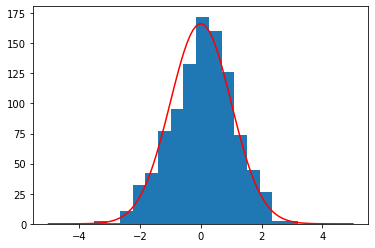

In [5]:
import matplotlib.pyplot as plt

fun = psycho_gen
Ntrials = 600
eta = np.linspace(np.log(0.01),np.log(1),num = 10)
bias = np.linspace(0.05,0.3,num = 10)
lapse = np.linspace(0.005,0.05,num = 10)
params = np.array(np.meshgrid(eta,bias,lapse)).T.reshape(-1,3)
dmat = 3*npr.rand(Ntrials)
Nexps = params.shape[0]
zscores = np.zeros(Nexps)

for i in range(Nexps):
    rmat = psycho_gen(params[i], dmat)
    ibs = IBS(fun, rmat, dmat, vectorized=True, acceleration=1.5, num_samples_per_call=0, max_iter=int(1e5), max_time=np.inf)
    nlogl, nlogl_var = ibs(params[i], num_reps=10, trial_weights=None, return_var = True, return_positive=False, return_std=False)
    nlogl_exact = psycho_nll(params[i], dmat, rmat)
    zscores[i] = (nlogl_exact-nlogl)/np.sqrt(nlogl_var)
    
plt.hist(zscores, bins = 16,  density = False)
# plot standard normal distribution in the same graph
x = np.linspace(-5,5,100)
plt.plot(x, (Nexps*5/6)*np.exp(-x**2/2)/np.sqrt(2*np.pi)/2, color = "red")

if np.abs(np.mean(zscores)) > 0.15:
    print("Warning: the mean of the z-scores is not close to zero")
if np.abs(np.std(zscores) - 1) > 0.1:
    print("Warning: the standard deviation of the z-scores is not close to one")

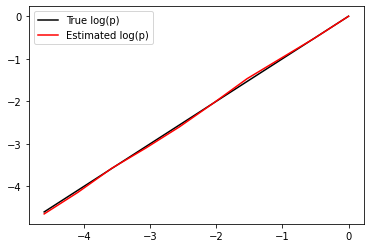

In [6]:
# Bernoulli model

Nreps = 600
p_model = np.exp(np.linspace(np.log(0.01),np.log(1),num = 10))
def fun(x, dmat):
    if dmat is None:
        return int(np.random.rand(1) < x)
    else:
        return np.vectorize(int)(np.random.rand(dmat.size) < x)

rmat = fun(1, None)
nlogl = np.zeros(len(p_model))
nlogl_var = np.zeros(len(p_model))
ibs = IBS(fun, rmat, None, vectorized=True, acceleration=1.5, num_samples_per_call=0, max_iter=int(1e5), max_time=np.inf)

for i in range(len(p_model)):
    nlogl[i], nlogl_var[i] = ibs(p_model[i], num_reps=Nreps, trial_weights=None, return_var = True, return_positive=False, return_std=False)

# We expect the true value to be almost certainly in this range
LL_min = nlogl - 4*np.sqrt(nlogl_var)
LL_max = nlogl + 4*np.sqrt(nlogl_var)
if np.any(np.log(p_model) < LL_min) or np.any(np.log(p_model) > LL_max):
    print("Warning: true value is not in the confidence interval")

plt.plot(np.log(p_model),np.log(p_model), color = "black")
plt.plot(np.log(p_model),nlogl, color = "red")
plt.legend(["True log(p)","Estimated log(p)"])

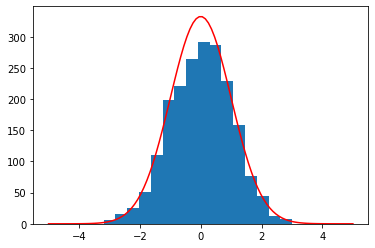

In [7]:
# Binomial model
import matplotlib.pyplot as plt

Ntrials = 100
p_model = 0.9*np.random.rand() + 0.05
p_true = 0.9*np.random.rand() + 0.05
def fun(x, dmat):
    if dmat is None:
        return int(np.random.rand(1) < x)
    else:
        return (np.random.rand(np.size(dmat)) < x)
    
Nexps = 2*10**3
zscores = np.zeros(Nexps)
for i in range(Nexps):
    rmat = fun(p_true, np.zeros(Ntrials)) 
    ibs = IBS(fun, rmat, None, vectorized=True, acceleration=1.5, num_samples_per_call=0, max_iter=int(1e5), max_time=np.inf)
    nlogl, nlogl_var = ibs(p_model, num_reps=10, trial_weights=None, return_var = True, return_positive=False, return_std=False)
    nlogl_exact = np.log(p_model)*np.sum(rmat) + np.log(1-p_model)*np.sum(rmat==False)
    zscores[i] = (nlogl_exact-nlogl)/np.sqrt(nlogl_var)
plt.hist(zscores, bins = 16, density = False)
# plot standard normal distribution in the same graph
x = np.linspace(-5,5,100) 
plt.plot(x, (Nexps*5/6)*np.exp(-x**2/2)/np.sqrt(2*np.pi)/2, color = "red")

if np.abs(np.mean(zscores)) > 0.15:
    print("Warning: the mean of the z-scores is not close to zero")
if np.abs(np.std(zscores) - 1) > 0.1:
    print("Warning: the standard deviation of the z-scores is not close to one")